In [1]:
!pip install contractions
!pip install transformers[torch] -U

# to remove the output of the installation
from IPython.display import clear_output
clear_output(wait=True)
print('Set up complete')

Set up complete


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import contractions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report

In [4]:
train_df = pd.read_csv("/content/drive/MyDrive/NLP_sentiment/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/NLP_sentiment/test.csv")
train_df.head()

,review,rating
0,Bromwell High is a cartoon comedy. It ran at t...,9
1,"If you like adult comedy cartoons, like South ...",7
2,Bromwell High is nothing short of brilliant. E...,9
3,"""All the world's a stage and its people actors...",10
4,FUTZ is the only show preserved from the exper...,8


# EDA

In [5]:
#Check for explicit missing values
train_df.isnull().sum(), test_df.isnull().sum()

(review    0
 rating    0
 dtype: int64,
 review    0
 rating    0
 dtype: int64)

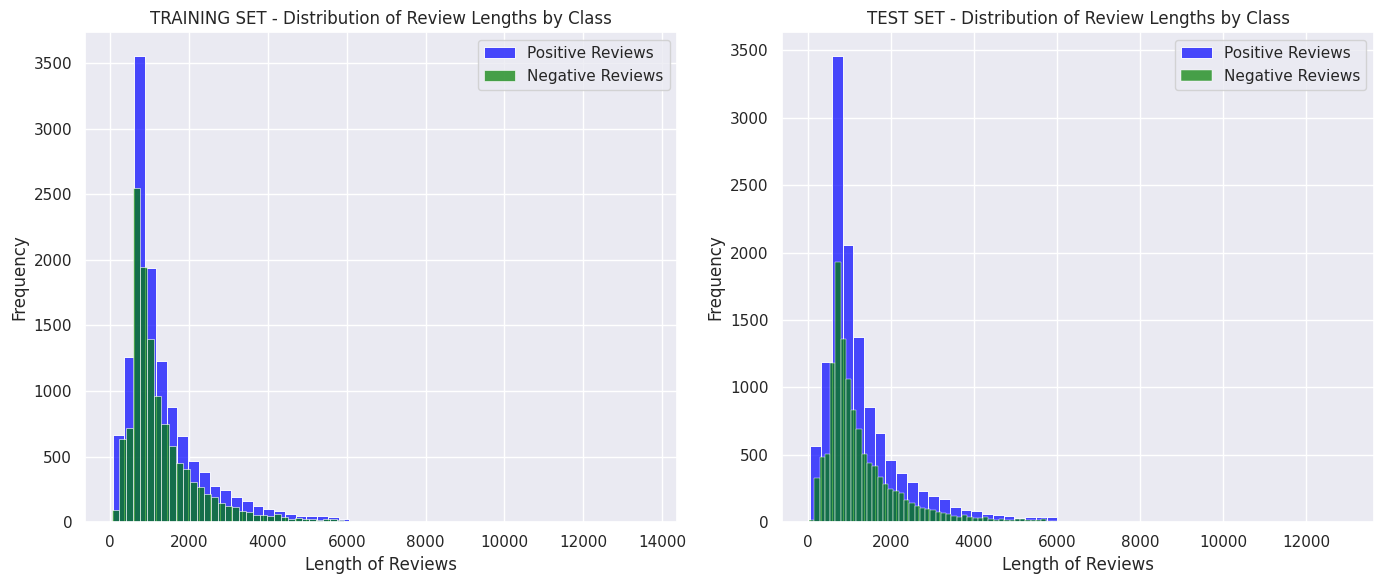

In [6]:
# Set the style for the plot
sns.set(style="darkgrid")

# Calculate review lengths
pos_reviews = train_df[train_df['rating'] > 5]['review'].apply(len)
neg_reviews = train_df[train_df['rating'] < 5]['review'].apply(len)
pos_reviews_test = test_df[test_df['rating'] > 5]['review'].apply(len)
neg_reviews_test = test_df[test_df['rating'] < 5]['review'].apply(len)

# Create a figure and a set of subplots
plt.figure(figsize=(14, 6))

# Plotting the review length distribution for TRAINING SET
plt.subplot(1, 2, 1)
sns.histplot(pos_reviews, bins=50, color='blue', alpha=0.7, label='Positive Reviews')
sns.histplot(neg_reviews, bins=50, color='green', alpha=0.7, label='Negative Reviews')
plt.title('TRAINING SET - Distribution of Review Lengths by Class')
plt.xlabel('Length of Reviews')
plt.ylabel('Frequency')
plt.legend()

# Plotting the review length distribution for TEST SET
plt.subplot(1, 2, 2)
sns.histplot(pos_reviews_test, bins=50, color='blue', alpha=0.7, label='Positive Reviews')
sns.histplot(neg_reviews_test, bins=50, color='green', alpha=0.7, label='Negative Reviews')
plt.title('TEST SET - Distribution of Review Lengths by Class')
plt.xlabel('Length of Reviews')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Preprocessing

In [7]:
# Transform ratings to either Positive or Negative (1,0)
train_df["rating"] = train_df["rating"].apply(lambda x: 1 if x > 5 else 0)
test_df["rating"] = test_df["rating"].apply(lambda x: 1 if x > 5 else 0)
train_df.head()

,review,rating
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,"If you like adult comedy cartoons, like South ...",1
2,Bromwell High is nothing short of brilliant. E...,1
3,"""All the world's a stage and its people actors...",1
4,FUTZ is the only show preserved from the exper...,1


In [8]:
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import unicodedata

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
# cleaning different patterns
def clean_review(text, bert = False):
    """
    It cleans the tokens from unrelevant characters
    """

    text = text.strip().lower()
    text = contractions.fix(text)
    text = re.sub(r'<.*?>', '', text) #removing HTMLS
    text = re.sub(r'http\S+|www\S+|email', '', text) #removing urls and emails
    text = re.sub(r'[^a-z\s]', ' ', text) # Remove special characters and numbers

    if not bert:
      words = word_tokenize(text) # Tokenize text
      # Lemmatize and remove stop words
      cleaned_text = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
      text = ' '.join(cleaned_text) # Join words back to string

    return text

In [10]:
# Applying text cleaning and lemmatization
train_df["lemmas"] = train_df["review"].apply(lambda r: clean_review(r))
test_df["lemmas"] = test_df["review"].apply(lambda r: clean_review(r))

In [11]:
#Extracting Dictionary
vocab = dict(sorted(nltk.FreqDist([word for text in train_df["lemmas"] for word in word_tokenize(text)]).items(),
                         key=lambda x: x[1], reverse=True))

len(vocab)

66294

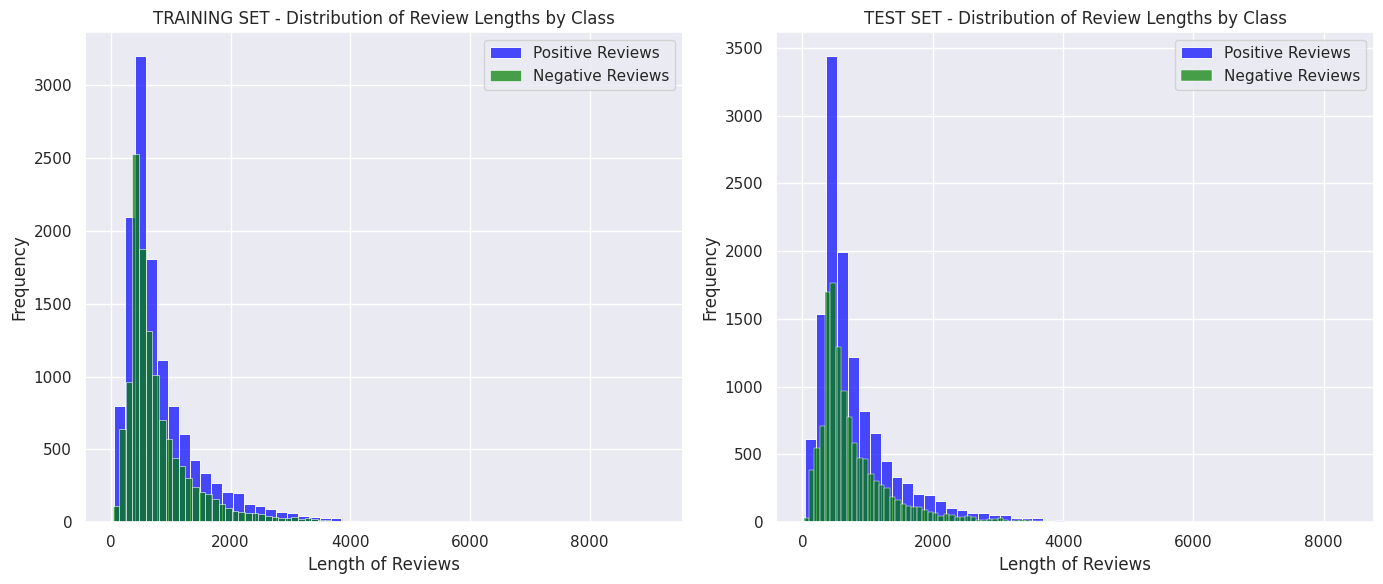

In [12]:
# NEW Len Distribution after cleaning

# Set the style for the plot
sns.set(style="darkgrid")

# Calculate review lengths
pos_reviews = train_df[train_df['rating'] == 1]['lemmas'].apply(len)
neg_reviews = train_df[train_df['rating'] == 0]['lemmas'].apply(len)
pos_reviews_test = test_df[test_df['rating'] == 1]['lemmas'].apply(len)
neg_reviews_test = test_df[test_df['rating']  == 0]['lemmas'].apply(len)

# Create a figure and a set of subplots
plt.figure(figsize=(14, 6))

# Plotting the review length distribution for TRAINING SET
plt.subplot(1, 2, 1)
sns.histplot(pos_reviews, bins=50, color='blue', alpha=0.7, label='Positive Reviews')
sns.histplot(neg_reviews, bins=50, color='green', alpha=0.7, label='Negative Reviews')
plt.title('TRAINING SET - Distribution of Review Lengths by Class')
plt.xlabel('Length of Reviews')
plt.ylabel('Frequency')
plt.legend()

# Plotting the review length distribution for TEST SET
plt.subplot(1, 2, 2)
sns.histplot(pos_reviews_test, bins=50, color='blue', alpha=0.7, label='Positive Reviews')
sns.histplot(neg_reviews_test, bins=50, color='green', alpha=0.7, label='Negative Reviews')
plt.title('TEST SET - Distribution of Review Lengths by Class')
plt.xlabel('Length of Reviews')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Removing len percentiles

In [35]:
train_review_lens = train_df.lemmas.apply(lambda x: len(x))
train_df["len"] = train_review_lens
print(f"Mean: {train_review_lens.mean()}")
print(f"Median: {train_review_lens.median()}")
print(f"Max: {train_review_lens.max()}")
print(f"Min: {train_review_lens.min()}")

Mean: 810.87144
Median: 595.0
Max: 9109
Min: 26


In [29]:
lower_bound_percentile = train_review_lens.quantile(.05)
upper_bound_percentile = train_review_lens.quantile(.9)

In [36]:
train_df = train_df[(train_df["len"] >= lower_bound_percentile) & (train_df["len"] <= upper_bound_percentile)]
len(train_df)

21254

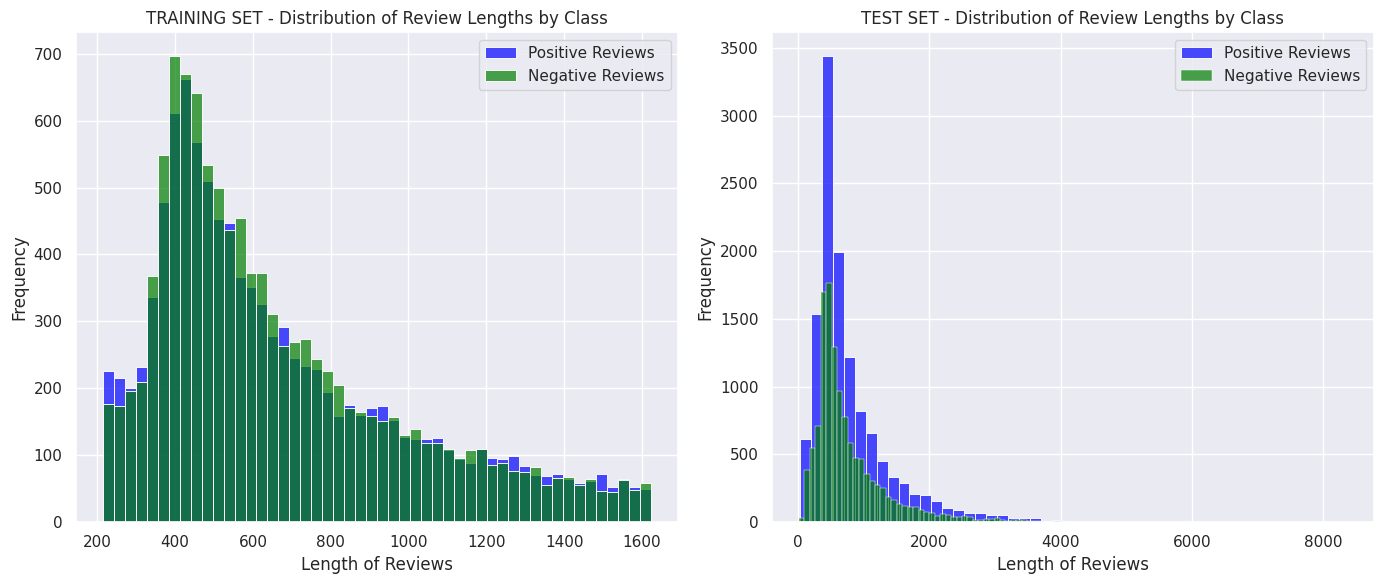

In [37]:
# NEW Len Distribution after cleaning

# Set the style for the plot
sns.set(style="darkgrid")

# Calculate review lengths
pos_reviews = train_df[train_df['rating'] == 1]['lemmas'].apply(len)
neg_reviews = train_df[train_df['rating'] == 0]['lemmas'].apply(len)
pos_reviews_test = test_df[test_df['rating'] == 1]['lemmas'].apply(len)
neg_reviews_test = test_df[test_df['rating']  == 0]['lemmas'].apply(len)

# Create a figure and a set of subplots
plt.figure(figsize=(14, 6))

# Plotting the review length distribution for TRAINING SET
plt.subplot(1, 2, 1)
sns.histplot(pos_reviews, bins=50, color='blue', alpha=0.7, label='Positive Reviews')
sns.histplot(neg_reviews, bins=50, color='green', alpha=0.7, label='Negative Reviews')
plt.title('TRAINING SET - Distribution of Review Lengths by Class')
plt.xlabel('Length of Reviews')
plt.ylabel('Frequency')
plt.legend()

# Plotting the review length distribution for TEST SET
plt.subplot(1, 2, 2)
sns.histplot(pos_reviews_test, bins=50, color='blue', alpha=0.7, label='Positive Reviews')
sns.histplot(neg_reviews_test, bins=50, color='green', alpha=0.7, label='Negative Reviews')
plt.title('TEST SET - Distribution of Review Lengths by Class')
plt.xlabel('Length of Reviews')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Modeling

In [13]:
# GETTING PRETRAINED EMBEDDINGS
import gensim.downloader as api

# Load the FastText model (this might take some time and require a fair amount of memory)
fasttext_model = api.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


In [14]:
# Split into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(
    train_df['lemmas'], train_df['rating'], test_size=0.2, shuffle=True, stratify=train_df['rating'].values, random_state=42)

y_test = test_df["rating"].values

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer

#
tokenizer = Tokenizer(num_words=len(vocab), oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(test_df['lemmas'])

In [16]:
# Reverse mapping from index to word
index_word = {i: word for word, i in tokenizer.word_index.items()}

def get_embeddings_for_text(tokenized_text, model):
    embeddings = [model[index_word.get(word, '<OOV>')] for word in tokenized_text if index_word.get(word, '<OOV>') in model.key_to_index]
    if len(embeddings) == 0:
        return np.zeros(model.vector_size)
    return np.mean(embeddings, axis=0)

# Get embeddings for train, validation, and test data
train_embeddings = [get_embeddings_for_text(text, fasttext_model) for text in train_sequences]
val_embeddings = [get_embeddings_for_text(text, fasttext_model) for text in val_sequences]
test_embeddings = [get_embeddings_for_text(text, fasttext_model) for text in test_sequences]

In [17]:
len(np.append(y_train, y_val))

25000

In [18]:
len(train_sequences + val_sequences + test_sequences)

50000

## SVM

In [19]:
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import numpy as np
import joblib  # For saving the model

X = np.array(train_embeddings + val_embeddings)
Y = np.append(y_train, y_val)

hyperparameters = [
    {'C': .5, 'kernel': 'rbf'},
    {'C': 1, 'kernel': 'rbf'},
    {'C': 5, 'kernel': 'rbf'},
    {'C': 10, 'kernel': 'rbf'}
]

num_folds = 5
kf = KFold(n_splits=num_folds)

best_accuracy = 0
best_params = None

for params in hyperparameters:
    accuracies = []

    for train_index, val_index in tqdm(kf.split(X)):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = Y[train_index], Y[val_index]

        svm_model = SVC(C=params['C'], kernel=params['kernel'])
        svm_model.fit(X_train, y_train)
        predictions = svm_model.predict(X_val)
        accuracy = accuracy_score(y_val, predictions)
        accuracies.append(accuracy)

    average_accuracy = np.mean(accuracies)
    print(f'Params: {params}, Average Accuracy: {average_accuracy}')

    if average_accuracy > best_accuracy:
        best_accuracy = average_accuracy
        best_params = params

# Re-train the best model on the full dataset
best_model = SVC(**best_params)
best_model.fit(X, Y)

# Save the best model
joblib.dump(best_model, 'best_svc_model.pkl')


5it [06:34, 78.95s/it]


Params: {'C': 0.5, 'kernel': 'rbf'}, Average Accuracy: 0.8420799999999999


5it [05:33, 66.64s/it]


Params: {'C': 1, 'kernel': 'rbf'}, Average Accuracy: 0.8462799999999999


5it [04:50, 58.11s/it]


Params: {'C': 5, 'kernel': 'rbf'}, Average Accuracy: 0.85036


5it [04:51, 58.27s/it]


Params: {'C': 10, 'kernel': 'rbf'}, Average Accuracy: 0.85212


['best_svc_model.pkl']

In [21]:
pred = best_model.predict(test_embeddings)
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

           0      0.852     0.851     0.851     12500
           1      0.851     0.852     0.851     12500

    accuracy                          0.851     25000
   macro avg      0.851     0.851     0.851     25000
weighted avg      0.851     0.851     0.851     25000



## LSTM

In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, AdamW

In [30]:
# Pad sequences
max_length = 300

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

In [31]:
train_padded.shape

(20000, 300)

## Training and Evaluating


In [32]:
# batch 16, units 128, max_length 400, AdamW 1e-4 -> TEST: 0.8746
# Model parameters
embedding_dim = 128
lstm_units = 128


early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=4,
    restore_best_weights=True
)

# Build the model
model = Sequential([
    Embedding(len(vocab), embedding_dim, input_length=max_length),
    Bidirectional(LSTM(lstm_units)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])

# Model summary
#model.summary()

# Train the model
epochs = 20
history = model.fit(train_padded, y_train, epochs=epochs, batch_size = 16,
                    validation_data=(val_padded, y_val), callbacks = [early_stopping])

Epoch 1/20
1250/1250 [==============================] - 152s 114ms/step - loss: 0.4902 - accuracy: 0.7665 - val_loss: 0.4092 - val_accuracy: 0.8290
Epoch 2/20
1250/1250 [==============================] - 62s 49ms/step - loss: 0.2530 - accuracy: 0.9089 - val_loss: 0.2869 - val_accuracy: 0.8824
Epoch 3/20
1250/1250 [==============================] - 58s 47ms/step - loss: 0.1583 - accuracy: 0.9481 - val_loss: 0.3174 - val_accuracy: 0.8786
Epoch 4/20
1250/1250 [==============================] - 61s 49ms/step - loss: 0.1000 - accuracy: 0.9692 - val_loss: 0.3040 - val_accuracy: 0.8872
Epoch 5/20
1250/1250 [==============================] - 38s 31ms/step - loss: 0.0757 - accuracy: 0.9808 - val_loss: 0.3861 - val_accuracy: 0.8778
Epoch 6/20
1250/1250 [==============================] - 41s 33ms/step - loss: 0.0465 - accuracy: 0.9868 - val_loss: 0.4494 - val_accuracy: 0.8772


## Testing

In [72]:
y_test = test_df.iloc[:, -2].values
y_pred = np.round(model.predict(test_padded)).flatten()

test_acc = accuracy_score(y_test, y_pred)
print(test_acc)
print(classification_report(y_test, y_pred, digits= 3))

782/782 [==============================] - 9s 10ms/step
0.86796
              precision    recall  f1-score   support

           0      0.864     0.873     0.869     12500
           1      0.872     0.863     0.867     12500

    accuracy                          0.868     25000
   macro avg      0.868     0.868     0.868     25000
weighted avg      0.868     0.868     0.868     25000



In [ ]:
# SAVE MODEL
model.save(f'lstm_{max_length}.h5')

# BERT

In [34]:
# Importing necessary libraries from transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [35]:
# Applying text cleaning - W/O lemmatization -
train_df["clean_review"] = train_df["review"].apply(lambda r: clean_review(r, bert=True))
test_df["clean_review"] = test_df["review"].apply(lambda r: clean_review(r, bert=True))

In [36]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df['clean_review'], train_df['rating'], test_size=0.2, shuffle=True, stratify=train_df['rating'].values, random_state=42)

In [37]:
# Function to tokenize the dataset
def tokenize_data(dataframe, tokenizer):
    if isinstance(dataframe, pd.DataFrame):
        return tokenizer(list(dataframe["clean_review"]), padding=True, truncation=True, max_length=512)
    return tokenizer(list(dataframe.values), padding=True, truncation=True, max_length=512)

In [38]:
# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the train and test data

train_encodings = tokenize_data(X_train, tokenizer)
val_encodings = tokenize_data(X_val, tokenizer)
test_encodings = tokenize_data(test_df["clean_review"], tokenizer)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [40]:
# Creating torch dataset
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

        if labels is not None:
            assert len(self.encodings['input_ids']) == len(self.labels), "Mismatch in lengths of encodings and labels"

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]).to(device) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx]).to(device)
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])


train_dataset = IMDbDataset(train_encodings, y_train.values)
val_dataset =   IMDbDataset(val_encodings, y_val.values)
test_dataset =  IMDbDataset(test_encodings, test_df['rating'].tolist())

In [ ]:
# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,   # batch size per device during training
    per_device_eval_batch_size=8,    # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=50,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset            # evaluation dataset
)

# Train the model and capture the output
trainer.train()

# Save the model
model.save_pretrained("./sentiment_model")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.680200
200,0.454500
300,0.388600
400,0.395500
500,0.531200
600,0.410800
700,0.411400
800,0.352600
900,0.379000
1000,0.317100


AttributeError: ignored

In [ ]:
model.save_pretrained("./transformers_3")

## Testing BERT

In [41]:
# Create test dataset using IMDbDataset
test_dataset = IMDbDataset(test_encodings)

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the model
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/NLP_sentiment/transformers_3')
model.to(device)

# Predict
model.eval()  # Set the model to evaluation mode
predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        # Move data to GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Move predictions back to CPU and collect them
        predictions.extend(torch.argmax(logits, dim=1).cpu().tolist())

# Extract true labels from the test dataset
true_labels = test_df["rating"].values#predictions.label_ids

# Generate a classification report
report = classification_report(true_labels, predictions, target_names=['Class 0', 'Class 1'], digits=3)  # Adjust target_names based on your classes
print(report)

100%|██████████| 782/782 [13:49<00:00,  1.06s/it]

              precision    recall  f1-score   support

     Class 0      0.937     0.919     0.928     12500
     Class 1      0.921     0.938     0.929     12500

    accuracy                          0.929     25000
   macro avg      0.929     0.929     0.929     25000
weighted avg      0.929     0.929     0.929     25000

